In [1]:
import math
import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim
from tensorflow.contrib.slim.python.slim import queues

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as mpcm

In [3]:
import sys
sys.path.append('../')

In [4]:
from datasets import dataset_factory
from nets import nets_factory
from preprocessing import preprocessing_factory

In [5]:
isess = tf.InteractiveSession()

## Some drawing routines

In [6]:
def colors_subselect(colors, num_classes=21):
    dt = len(colors) // num_classes
    sub_colors = []
    for i in range(num_classes):
        color = colors[i*dt]
        if isinstance(color[0], float):
            sub_colors.append([int(c * 255) for c in color])
        else:
            sub_colors.append([c for c in color])
    return sub_colors

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Draw a collection of lines on an image.
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_rectangle(img, p1, p2, color=[255, 0, 0], thickness=2):
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    
    
def draw_bbox(img, bbox, shape, label, color=[255, 0, 0], thickness=2):
    p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
    p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    p1 = (p1[0]+15, p1[1])
    cv2.putText(img, str(label), p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)


def bboxes_draw_on_img(img, classes, scores, bboxes, colors, thickness=2):
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        color = colors[classes[i]]
        # Draw bounding box...
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
        # Draw text...
        s = '%s/%.3f' % (classes[i], scores[i])
        p1 = (p1[0]-5, p1[1])
        cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.4, color, 1)


In [7]:
colors = colors_subselect(mpcm.plasma.colors, num_classes=21)
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

## Pascal VOC dataset

Check the Pascal VOC pipeline and associated TFRecords files.

In [8]:
from datasets import pascalvoc_2007
from datasets import pascalvoc_2012

DATASET_DIR = '/media/paul/DataExt4/PascalVOC/dataset/'
SPLIT_NAME = 'train'
BATCH_SIZE = 16

# Dataset provider loading data from the dataset.
dataset = pascalvoc_2007.get_split(SPLIT_NAME, DATASET_DIR)
provider = slim.dataset_data_provider.DatasetDataProvider(dataset, 
                                                          shuffle=False,
#                                                           num_epochs=1,
                                                          common_queue_capacity=2 * BATCH_SIZE,
                                                          common_queue_min=BATCH_SIZE)
[image, shape, bbox, label] = provider.get(['image', 'shape', 'object/bbox', 'object/label'])
print('Dataset:', dataset.data_sources)
# dataset.num_samples

Dataset: /media/paul/DataExt4/PascalVOC/dataset/voc_2007_train.tfrecord


In [9]:
# images = tf.train.batch(
#                 [image_crop],
#                 batch_size=BATCH_SIZE,
#                 num_threads=1,
#                 capacity=5 * BATCH_SIZE)

In [10]:
# Problem: image shape is not fully defined => random crop with deterministic size.
xy = tf.random_uniform((2, ), minval=0, maxval=shape[0] // 3, dtype=tf.int64)
image_crop = tf.slice(image, [0, 0, 0], [250, 250, 3])

print('Original vs crop:', image.get_shape(), image_crop.get_shape())

Original vs crop: (?, ?, 3) (250, 250, 3)


In [11]:
# with queues.QueueRunners(sess):
# Start populating queues.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

In [12]:
# Draw groundtruth bounding boxes using TF routine.
image_bboxes = tf.squeeze(tf.image.draw_bounding_boxes(tf.expand_dims(tf.to_float(image) / 255., 0), 
                                                       tf.expand_dims(bbox, 0)))

Image shape: (375, 500, 3) [375 500   3]
Bounding boxes: [[ 0.56266665  0.52600002  0.90399998  0.648     ]
 [ 0.704       0.33000001  0.99199998  0.50599998]
 [ 0.65066665  0.01        0.99733335  0.134     ]
 [ 0.51733333  0.48199999  0.79733336  0.58999997]
 [ 0.49599999  0.55400002  0.58666664  0.62400001]]
Labels: [16 16 16 16 16]


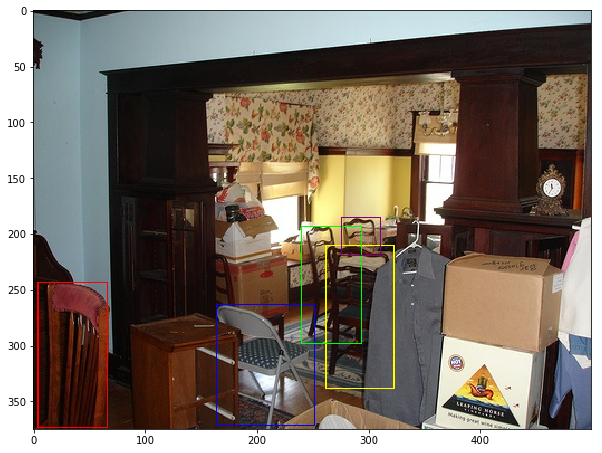

In [13]:
# Eval and display the image + bboxes.
rimg, rshape, rbboxes, rlabels = isess.run([image_bboxes, shape, bbox, label])

print('Image shape:', rimg.shape, rshape)
print('Bounding boxes:', rbboxes)
print('Labels:', rlabels)

fig = plt.figure(figsize = (10,10))
plt.imshow(rimg)

## Test original SSD-300 model

Restore model and test it on some random images.

In [14]:
from nets import ssd_vgg_300
from nets import ssd_common

from preprocessing import ssd_preprocessing

ckpt_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.ckpt'

In [15]:
# Image pre-processimg
out_shape = (300, 300) 
image_pre = ssd_preprocessing.preprocess_for_eval(image, 
                                                  out_shape, 
                                                  resize=ssd_preprocessing.Resize.PAD_AND_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# SSD construction.
params = ssd_vgg_300.SSDNet.default_params
ssd = ssd_vgg_300.SSDNet(params)
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False)
    
# SSD default anchor boxes.
img_shape = (300, 300)
layers_anchors = ssd.anchors(img_shape, dtype=np.float32)

In [23]:
# Targets encoding.
feat_labels, feat_localizations, feat_scores = ssd_common.tf_ssd_bboxes_encode(label, bbox, layers_anchors[1])
print(bbox.get_shape())
print(label.get_shape())

print(feat_labels.get_shape())
print(feat_localizations.get_shape())
print(feat_scores.get_shape())


(?, 4)
(?,)
(19, 19, 6)
(19, 19, 6, 4)
(19, 19, 6)


In [17]:
# print(params.anchor_size_bounds)
# print(params.anchor_sizes)
print(layers_anchors[0][0].shape)
print(layers_anchors[0][2].shape)

(38, 38, 1)
(4,)


In [18]:
# Initialize variables.
init_op = tf.global_variables_initializer()
isess.run(init_op)
# Restore SSD model.
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

In [19]:
# Run model.
rimg, rpredictions, rlocalisations, rlabels = isess.run([image_4d, predictions, localisations, label])

In [20]:
# Compute classes and bboxes from the net outputs.
classes, scores, bboxes = ssd_common.ssd_bboxes_from_layers(rpredictions, rlocalisations, layers_anchors,
                                                threshold=0.6, img_shape=img_shape, num_classes=21)
classes, scores, bboxes = ssd_common.bboxes_sort(classes, scores, bboxes, top_k=400)
classes, scores, bboxes = ssd_common.bboxes_nms(classes, scores, bboxes, threshold=0.35)


Labels / scores: [(7, 0.99958605)]


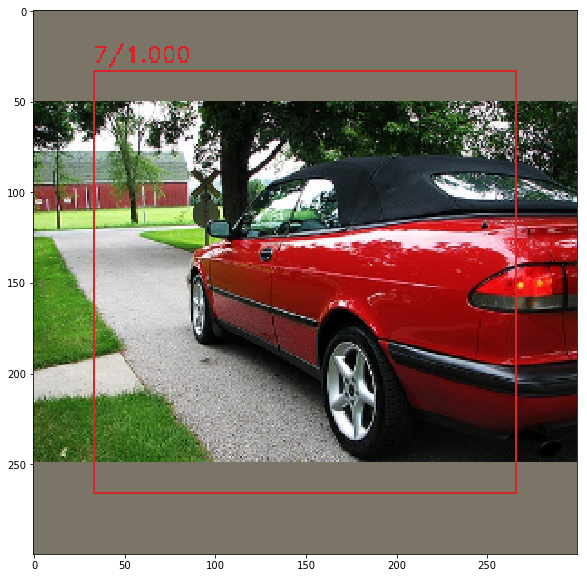

In [21]:
# Draw bboxes
img_bboxes = np.copy(ssd_preprocessing.np_image_unwhitened(rimg[0]))
bboxes_draw_on_img(img_bboxes, classes, scores, bboxes, colors_tableau, thickness=1)

print('Labels / scores:', list(zip(classes, scores)))
fig = plt.figure(figsize = (10,10))
plt.imshow(img_bboxes)

In [22]:
fig = plt.figure(figsize = (8,8))
plt.imshow(unpreprocess_image(rimg[0]))
print('Ground truth labels: ', rlabels)

NameError: name 'unpreprocess_image' is not defined

In [ ]:
# Request threads to stop. Just to avoid error messages
coord.request_stop()
coord.join(threads)

## Some TensorFlow tests...

In [ ]:
a = tf.constant([[5.0, 2], [5.0, 2]])
b = tf.constant([5.0, 2])
c = a * b
d = tf.nn.l2_normalize(a, dim=1)
# We can just use 'c.eval()' without passing 'sess'
print(d.eval())

## A few test on Caffe model files...

In [ ]:
import caffe
import numpy as np
from caffe.proto import caffe_pb2

caffe_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.caffemodel'
caffemodel_params = caffe_pb2.NetParameter()
caffemodel_str = open(caffe_filename, 'rb').read()
caffemodel_params.ParseFromString(caffemodel_str)


In [ ]:
layers = caffemodel_params.layer
names = [(i, l.name) for i, l in enumerate(layers)]
types = set([l.type for i, l in enumerate(layers)])
print(types)
names

In [ ]:
layer = layers[59]
layer = layers[1]
print(layer.type)
a = np.array(layer.blobs[0].data)
s = layer.blobs[0].shape
print(s, 38*38)
# print(a)

In [ ]:
from nets import caffe_scope

In [ ]:
csc = caffe_scope.CaffeScope()

In [ ]:
d = {}
d[csc.conv_biases_init] = 0
d[csc.conv_biases_init] += 1

In [ ]:
min_dim = 300
mbox_source_layers = ['conv4_3', 'fc7', 'conv6_2', 'conv7_2', 'conv8_2', 'conv9_2']
min_ratio = 15
max_ratio = 90
step = int(math.floor((max_ratio - min_ratio) / (len(mbox_source_layers) - 2)))
min_sizes = []
max_sizes = []
for ratio in range(min_ratio, max_ratio + 1, step):
    min_sizes.append(min_dim * ratio / 100.)
    max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 7 / 100.] + min_sizes
max_sizes = [min_dim * 15 / 100.] + max_sizes

In [ ]:
print(min_sizes)
print(max_sizes)


In [ ]:
feat_shapes=[(38, 38), (19, 19), (10, 10), (5, 5), (3, 3), (1, 1)]

In [ ]:
steps = [8, 16, 32, 64, 100, 300]
offset = 0.5

In [ ]:
for i in range(len(steps)):
    print((feat_shapes[i][0] - offset) * steps[i] / 300, (feat_shapes[i][0] - offset) / feat_shapes[i][0])

In [ ]:
37.5 * 8. / 300

In [ ]:
.5 / 38